In [1]:
import numpy as np
import os
import pyarrow
import sys
import json
import math
import mpl_utils

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET

import pandas as pd
import polars as pl


# Directories

In [2]:
sys.path.append("../../functions")
import Demand_functions as dmd

In [3]:
# General directories
general_directory = '/Users/andre/Desktop/Cergy/'

berlin_directory = 'MATSim/matsim-berlin/input/v6.4/'

run_dir = "Python_Scripts/runs/"

In [4]:
# metro
METRO_INPUT = (os.path.join(general_directory, run_dir, "dt_choice/metro_inputs/"))

METRO_OUTPUT = (os.path.join(general_directory, run_dir, "dt_choice/metro_outputs/"))

BERLIN_PATH = ((os.path.join(general_directory, berlin_directory, "parquet/")))

ACTIVITY_TYPES_PATH = ((os.path.join(general_directory, berlin_directory, "berlin-v6.4.output_config_reduced.xml")))

# Path to MATSim's experienced plans.
PLAN_PATH = "/Users/andre/Desktop/Cergy/Python_Scripts/runs/fixed_10pct/matsim/"

# Path to the directory where the Metropolis output is stored.
#MATSIM_TRIPS = (os.path.join(general_directory, run_dir, "avg_10runs/metro_outputs/"))


# Read Plans

In [5]:
def read_matsim_plans():
    persons = pl.read_parquet(os.path.join(BERLIN_PATH, 'MATSim_persons.parquet'))
    plans = pl.read_parquet(os.path.join(BERLIN_PATH, 'MATSim_plans.parquet'))
    activities = pl.read_parquet(os.path.join(BERLIN_PATH, 'MATSim_activities.parquet'))
    legs = pl.read_parquet(os.path.join(BERLIN_PATH, 'MATSim_legs.parquet'))
    routes = pl.read_parquet(os.path.join(BERLIN_PATH, 'MATSim_routes.parquet'))

    return persons, plans, activities, legs, routes

In [6]:
def read_metropolis_results():
    agents = pl.read_parquet(os.path.join(METRO_OUTPUT, "agent_results.parquet"))
    trips = pl.read_parquet(os.path.join(METRO_OUTPUT, "trip_results.parquet"))
    routes = pl.read_parquet(os.path.join(METRO_OUTPUT, "route_results.parquet"))
    return agents, trips, routes

In [7]:
trip_inputs = pl.read_parquet(os.path.join(METRO_INPUT, "trips.parquet"))

In [8]:
print("Reading MATSim experienced plans")
persons, plans, activities, legs, routes = read_matsim_plans()

print("Reading METROPOLIS results")
mp_agents, mp_trips, mp_routes = read_metropolis_results()

print("Reading MATSim detailed trips")
matsim_trips = pl.read_parquet(os.path.join(general_directory, run_dir, 'pt_10pct/matsim_trips/MATSim_trips.parquet'))

Reading MATSim experienced plans
Reading METROPOLIS results
Reading MATSim detailed trips


# Travel Cost

In [9]:
matsim_trips = (
    matsim_trips
    .with_columns((pl.col("plan_id")).alias("agent_id")) # agent_id = plan_id
    .join(trip_inputs.select(['agent_id', 'alt_id', 'trip_id', 'stopping_time']), on=['agent_id', 'trip_id'])
    .drop(['start_time_secs', 'is_tour_anchor', 'end_time_secs', 'type_or_mode', 
                                  'element_type', 'seq_index_right'])
    .join(plans.select(['person_id', 'score']), on='person_id')
)


mp_trips = ( 
    mp_trips
    .select(['agent_id', 'trip_id', 'trip_index', 'departure_time', 'arrival_time','road_time', 
             'length', 'nb_edges'])
    .join(matsim_trips.select(['agent_id', 'trip_id', 'mode', 'plan_id']), on=['agent_id', 'trip_id'])
)

mp_trips = dmd.mode_utility_params(mp_trips)

 # only available for metropolis output
mp_trips = mp_trips.with_columns((pl.col('C')+pl.col('length')*pl.col('gamma_dist')).alias('constant_utility'))

# Activity Utility

## Activity list data frame

In [10]:
activity_types = dmd.read_activity_parameters(ACTIVITY_TYPES_PATH)

In [11]:
def activities_and_trips(trips, activity_types, activities):
    
    activity_types= activity_types.with_columns(pl.when(pl.col('typical_duration')=='undefined')
                                            .then(pl.lit(None).alias('typical_duration'))
                                            .otherwise(pl.col('typical_duration')))
    activities_clean = (
    activities
    .join(activity_types, on='type')
    .join(plans, left_on='plan_id', right_on='id')
    .with_columns([
        pl.arange(0, pl.len()).over("plan_id").alias("activity_index"),
        dmd.hhmmss_str_to_seconds_expr(('typical_duration')),
        dmd.hhmmss_str_to_seconds_expr(('opening_time')),
        dmd.hhmmss_str_to_seconds_expr(('closing_time'))
                  ])
    .select(['person_id','plan_id', 'activity_index', 'id', 'type', 'typical_duration_secs',
             'opening_time_secs', 'closing_time_secs', 'score'])
    )
    
    # Join trips i with activity i+1
    trips = trips.with_columns([pl.arange(1, pl.len()+1).over("plan_id").alias("activity_index")])
    
    
    trips_with_activities = (
    activities_clean
    .rename({'typical_duration_secs': 'typical_duration', 
             'opening_time_secs': 'opening_time',
             'closing_time_secs': 'closing_time'})
    .join(trips, on=['plan_id', 'activity_index'], how='left'))
    
    trips_with_activities = (
    trips_with_activities
    .with_columns([
        pl.col("departure_time").shift(-1).over("person_id").alias("end_time"),
        pl.col("arrival_time").alias("start_time"),
        pl.col('type').alias("activity_type"),
        (pl.col('arrival_time')-pl.col('departure_time')).alias('travel_time')
    ])
    .select(['person_id', 'plan_id', 'trip_id', 'activity_index', 'mode', 'length', 
             'departure_time', 'arrival_time', 'travel_time', 'activity_type', 'start_time', 'end_time',
             'typical_duration', 'constant_utility', 'score', 'opening_time', 'closing_time']))
    trips_with_activities = (
    trips_with_activities
    .with_columns([
        pl.when(pl.col('activity_index')==0)
        .then(pl.lit(0))
        .otherwise(pl.col('start_time')).alias('start_time') # avoid filtering out the 1st act (null start_time)
    ])    
    .filter(pl.col('start_time')<86400) # filter out events after midnight
)
    
    return trips_with_activities

In [12]:
trips_with_activities = activities_and_trips(mp_trips, activity_types, activities)

## Matching and non-matching Activities (first-last)

To create an indicator for matching (or non-matching) first and last activities, we create a bolean variable.


If the first and last activities match, $activity_0$ `start_time` = `end_time` to set a duration of 0 for the first activity. Analogously, for $activity_n$, `end_time = 86400 + start_time(first_activity)`.

If they don't match, $activity_0$ `start_time = 0` and $activity_n$, `end_time = 86400`


All events after midnight are not accounted for in utility.

$\forall \text{ activity } q,$ `start_time`$_q$ $\geq 24h,\ \ Score_q = 0$ 


In [13]:
# Create an indicator for matching (or non-matching) first and last activities, we do:
trips_with_activities = (
    trips_with_activities
    .with_columns([
        pl.len().over("plan_id").alias("n_activities") # max activities per plan
    ])
    .with_columns([
        (
            (pl.col("activity_type").first().over("plan_id") == pl.col("activity_type").last().over("plan_id")) &
            (
                (pl.col("activity_index") == 0) |
                (pl.col("activity_index") == (pl.col("n_activities") - 1))
            ) & (
                (pl.col("end_time").last().over("plan_id") >= 86400) |
                (pl.col("end_time").last().over("plan_id").is_null())  
            )
        ).alias("matching_activities")
    ])
    .with_columns([
        # START_TIME
        pl.when((pl.col("activity_index") == 0) & pl.col("matching_activities"))
        .then(pl.col("end_time"))
        .when(pl.col("activity_index") == 0)
        .then(0)
        .otherwise(pl.col("start_time"))
        .alias("start_time_adjusted")
    ])
    .with_columns([
        # END_TIME
        pl.when((pl.col("activity_index") == (pl.col("n_activities") - 1)) & pl.col("matching_activities"))
        .then(86400 + pl.col("start_time_adjusted").first().over("plan_id"))
        .when(pl.col("activity_index") == (pl.col("n_activities") - 1))
        .then(86400)
        .otherwise(pl.col("end_time"))
        .alias("end_time_adjusted")
    ])
    .drop(['start_time', 'end_time'])
    .rename({
    "start_time_adjusted": "start_time",
    "end_time_adjusted": "end_time"
    })
)


Here we only compute activity duration based on the "utility window". That is between opening and closing times

In [14]:
trips_with_activities= (
    trips_with_activities
    .with_columns([
        (pl.col('end_time')-pl.col('start_time')).alias('activity_duration')
])
    .with_columns([
        pl.max_horizontal('activity_duration', 0).cast(pl.Float64) # just a check
    ])

)

In [15]:
# Opening and Closing times
trips_with_activities= (
    trips_with_activities
    .with_columns([
        pl.max_horizontal('opening_time', 'start_time').alias('start_time'),
        pl.min_horizontal('end_time', 'closing_time').alias('end_time')
    ])
)

In [16]:
trips_with_activities= (
    trips_with_activities
    .with_columns([
        pl.when(pl.col('activity_duration') >= pl.col('typical_duration')*np.exp(-1))
        .then(
            6.88 / 3600 * pl.col('typical_duration') *
            (1 + (pl.col('activity_duration') / pl.col('typical_duration')).log()
            )
        )
        .otherwise(6.88 / 3600 *(pl.col('activity_duration')*np.e-pl.col('typical_duration')))
        .fill_null(0).alias('activity_utility')
    ])
)

In [17]:
trips_with_activities = (
    trips_with_activities
    .with_columns([
        pl.when(pl.col('mode')=='ride')
        .then(-6.88/3600*pl.col('travel_time'))
        .otherwise(pl.lit(0)).alias('beta_trav')])
)

In [18]:
trips_with_activities = trips_with_activities.with_columns([
    pl.when((pl.col('matching_activities')) & (pl.col('activity_index') == 0))
    .then(pl.lit(0))
    .otherwise(pl.col('activity_utility'))
    .alias('activity_utility')
])

In [19]:
trips_with_activities= (
    trips_with_activities
    .with_columns([
        (pl.col('beta_trav') + pl.col('constant_utility')).alias('travel_utility').fill_null(0)
    ])
    .drop(['beta_trav',
           'opening_time', 'closing_time', 'n_activities', 'matching_activities', 'constant_utility'])
)

## Exclude activities with dt after 24h (utility not accounted for)

### Define main mode for each plan

In [20]:
trips_with_activities = trips_with_activities.with_columns([
    pl.col("mode").fill_null("unknown")
])

only_walk = (
    trips_with_activities
    .group_by("plan_id")
    .agg((pl.col("mode") == "walk").all().alias("only_walk"))
)

most_used_non_walk = (
    trips_with_activities
    .filter(pl.col("mode") != "walk")
    .group_by(["plan_id", "mode"])
    .agg(pl.len().alias("mode_count"))
    .group_by("plan_id")
    .agg(
        pl.col("mode")
        .filter(pl.col("mode_count") == pl.col("mode_count").max())
        .first()
        .alias("most_used_mode")
    )
)

main_mode_logic = (
    only_walk
    .join(most_used_non_walk, on="plan_id", how="left")
    .with_columns([
        pl.when(pl.col("only_walk"))
        .then(pl.lit("walk"))
        .otherwise(pl.col("most_used_mode"))
        .alias("main_mode")
    ])
    .select(["plan_id", "main_mode"]))

# Utility

In [21]:
def get_utility_per_plan(trips_with_activities, main_mode_logic):
    plan_utilities = (
    trips_with_activities
    .group_by("plan_id")
    .agg([
        pl.col("person_id").first(),
        pl.col("activity_utility").sum().fill_null(0),
        pl.col("travel_utility").sum().fill_null(0),
        (pl.col("mode") == "car").any().alias("uses_car"),
        (pl.col("mode") == "pt").any().alias("uses_pt"),
        pl.col("score").first().cast(pl.Float64).alias("matsim_score"),
        pl.col("mode").unique().alias("modes")
    ])
    .with_columns([
        (pl.when(pl.col("uses_car")).then(-5).otherwise(0) +
         pl.when(pl.col("uses_pt")).then(-3).otherwise(0)).alias("daily_monetary_constant")
    ])
    .join(main_mode_logic, on="plan_id", how="left")
    .select([
        "plan_id",
        "person_id",
        "matsim_score",
        "activity_utility",
        "travel_utility",
        "daily_monetary_constant",
        "main_mode"
    ])
    .with_columns([
        (pl.col("activity_utility") + pl.col("travel_utility") + pl.col("daily_monetary_constant"))
        .alias("total_utility")
    ])
    .select(['person_id', 'plan_id', 'travel_utility', 'main_mode', 'activity_utility', 
             'daily_monetary_constant', 'total_utility', 'matsim_score'])
    .sort('plan_id')
    .with_columns([
        (pl.col('matsim_score') - pl.col('total_utility')).alias('utility_diff')])
    )
    return plan_utilities

In [22]:
plan_utilities=get_utility_per_plan(trips_with_activities, main_mode_logic)

In [23]:
plan_utilities['utility_diff'].describe()

statistic,value
str,f64
"""count""",526111.0
"""null_count""",0.0
"""mean""",3.706076
"""std""",33.958755
"""min""",-576.427371
"""25%""",-1.73782
"""50%""",0.0
"""75%""",1.865747
"""max""",292.732285


In [24]:
car_utilities = plan_utilities.filter(daily_monetary_constant=-5)
car_utilities['utility_diff'].describe()

statistic,value
str,f64
"""count""",116462.0
"""null_count""",0.0
"""mean""",21.000996
"""std""",35.723873
"""min""",-514.99605
"""25%""",1.572159
"""50%""",8.292872
"""75%""",33.18587
"""max""",232.338501


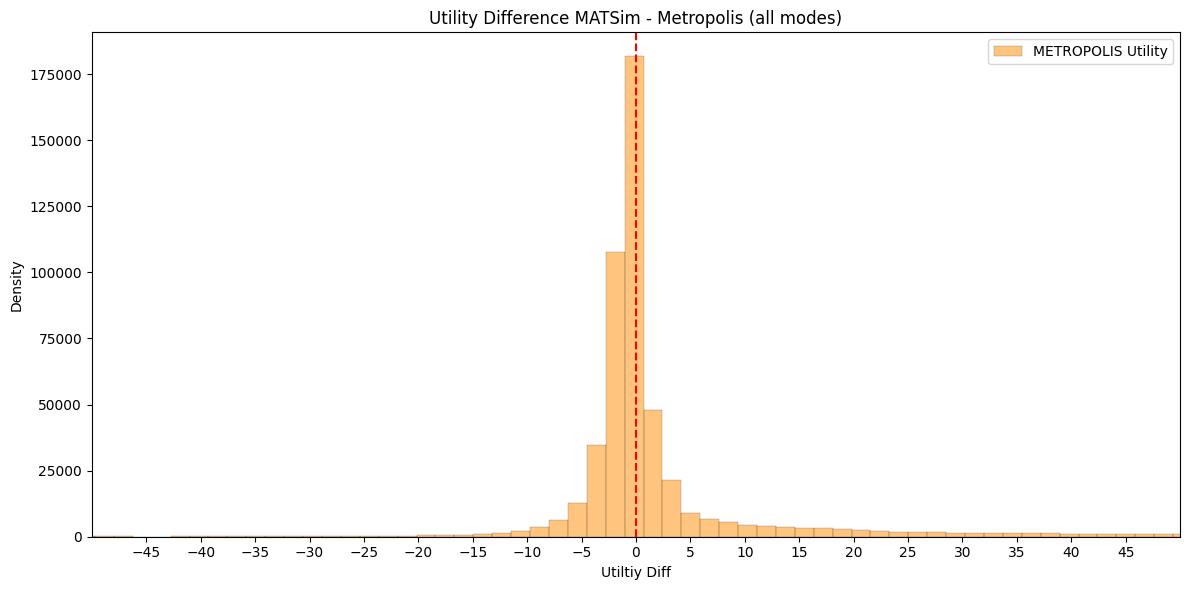

In [25]:
xticks = np.arange(-45, 46, 5)

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(
    plan_utilities['utility_diff'],
    bins=500,
    alpha=0.5,
    color="darkorange",
    kde=False,
    label="METROPOLIS Utility"
)

# Line in 0
plt.axvline(0, color="red", linestyle="--")

plt.xlim(-50, 50)
plt.xticks(xticks)
plt.title("Utility Difference MATSim - Metropolis (all modes)")
plt.xlabel("Utiltiy Diff")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

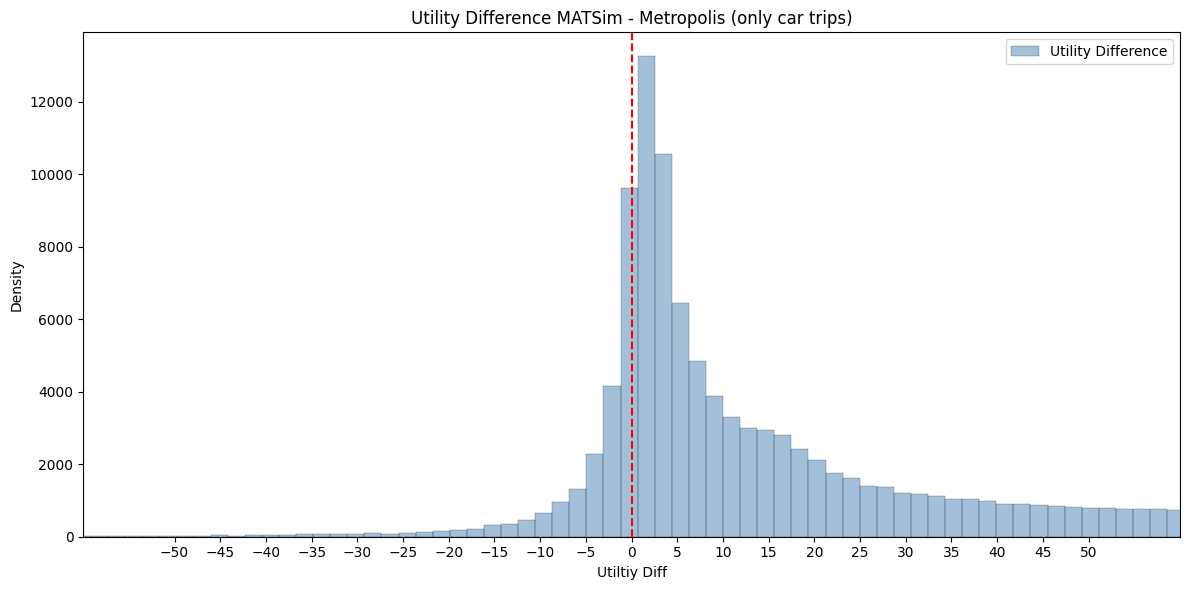

In [26]:
xticks = np.arange(-50, 51, 5)

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(
    car_utilities['utility_diff'],
    bins=400,
    alpha=0.5,
    color="steelblue",
    kde=False,
    label="Utility Difference"
)

# Line in 0
plt.axvline(0, color="red", linestyle="--")

plt.xlim(-60, 60)
plt.xticks(xticks)
plt.title("Utility Difference MATSim - Metropolis (only car trips)")
plt.xlabel("Utiltiy Diff")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()